# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
!pip install --upgrade torch torchvision
!pip install Pillow==5.3.0

    100% |████████████████████████████████| 591.8MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x60e16000 @  0x7f8595d722a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.2.1)
  Found existing installation: torch 0.3.0.post4
    Uninstalling torch-0.3.0.post4:
      Successfully uninstalled torch-0.3.0.post4


In [1]:
# Imports here
from torch import nn, optim
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from __future__ import print_function, division
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy

import PIL
print(PIL.PILLOW_VERSION)

plt.ion()   # interactive mode

5.1.0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

replace flower_data/valid/61/image_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace flower_data/valid/61/image_06293.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [3]:
# TODO: Define your transforms for the training and validation sets

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

print("Dataset Sizes:   ", dataset_sizes)

Dataset Sizes:    {'train': 6552, 'valid': 818}


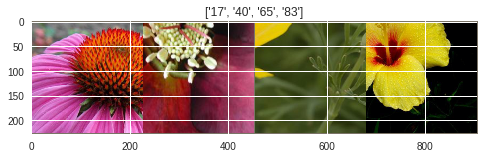

In [46]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [47]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [50]:
# TODO: Build and train your network
from collections import OrderedDict
densenet_model = models.densenet161(pretrained=True)
#print(vgg16_model)

for param in densenet_model.parameters():
  param.requires_grad = False

num_features = densenet_model.classifier.in_features

print("num_features:   ", num_features)

"""

densenet_classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(num_features, 1024)),
                              ('relu', nn.ReLU()),
                              ('drpot', nn.Dropout(p=0.5)),
                              ('hidden', nn.Linear(1024, 120)),                       
                              ('fc2', nn.Linear(120, 102)),
                              ('output', nn.LogSoftmax(dim=1)),
                              ]))

"""
densenet_classifier = nn.Sequential(OrderedDict([
                              ("fc1", nn.Linear(num_features, 1024)),
                              ("relu1",nn.ReLU()),
                              ("drpot1", nn.Dropout(p=0.5)),
                              ("fc2", nn.Linear(1024, 512)), 
                              ("relu2",nn.ReLU()),
                              ("drpot2",nn.Dropout(p=0.3)),
                              ("fc3",nn.Linear(512, 120)), 
                              ("relu3",nn.ReLU()),
                              ("drpot3",nn.Dropout(p=0.5)),
                              ("fc2",nn.Linear(120, 102)),
                              ("output",nn.LogSoftmax(dim=1)),
                              ]))


"""
densenet_classifier = nn.Sequential(OrderedDict(nn.Linear(25088,8912),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3),
                                 nn.Linear(8912,4096),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3),
                                 nn.Linear(4096,120),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3),
                                 nn.Linear(120,102),
                                 nn.LogSoftmax(dim=1))
                                  )

"""

densenet_model.fc = densenet_classifier

#print(densenet_model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.classifier.parameters(),lr = 0.003)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


num_features:    2208


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [52]:
print("Device Available:  ", device)

for param in densenet_model.parameters():
  param.requires_grad = True


Device Available:   cuda


In [53]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            print("Phase Details:  " , phase,"   ", len(dataloaders[phase]))
            count = 0
            for inputs, labels in dataloaders[phase]:
                length = len(dataloaders[phase])
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                count = count + 1
                if (count % 500 == 0):
                    print("Statistics:   ", count)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed / 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

best_model = train_model(densenet_model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
Phase Details:   train     1638
Statistics:    500
Statistics:    1000
Statistics:    1500
train Loss: 3.2716 Acc: 0.3961
Phase Details:   valid     205
valid Loss: 1.2985 Acc: 0.7751

Epoch 1/14
----------
Phase Details:   train     1638
Statistics:    500
Statistics:    1000
Statistics:    1500
train Loss: 1.7810 Acc: 0.6302
Phase Details:   valid     205
valid Loss: 0.6044 Acc: 0.8729

Epoch 2/14
----------
Phase Details:   train     1638
Statistics:    500
Statistics:    1000
Statistics:    1500
train Loss: 1.6472 Acc: 0.6821
Phase Details:   valid     205
valid Loss: 0.5354 Acc: 0.8985

Epoch 3/14
----------
Phase Details:   train     1638
Statistics:    500
Statistics:    1000
Statistics:    1500
train Loss: 0.6148 Acc: 0.8460
Phase Details:   valid     205
valid Loss: 0.2790 Acc: 0.9487

Epoch 4/14
----------
Phase Details:   train     1638
Statistics:    500
Statistics:    1000
Statistics:    1500
train Loss: 0.5835 Acc: 0.8610
Phase Details:   valid     2

# New Section

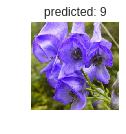

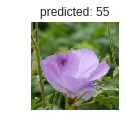

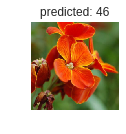

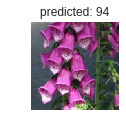

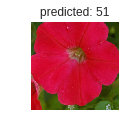

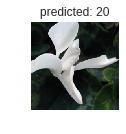

In [65]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
visualize_model(best_model)

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 

best_model.class_to_idx = dataloaders['train'].dataset.class_to_idx
best_model.epochs = 15
"""
checkpoint = {   'batch_size': dataloaders['train'].batch_size,
                  'output_size': 102,
                  'state_dict': best_model.state_dict(),
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': best_model.class_to_idx,
                  'epoch': best_model.epochs}

"""

#torch.save(best_model, 'checkpoint_1.pth')

torch.save(best_model.state_dict(),"checkpoint_2.pth")


In [63]:
from google.colab import files
files.download('checkpoint_2.pth')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 48400, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [12]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
#torch.load with map_location='cpu'
state_dict = torch.load("checkpoints/checkpoint_2_new.pth",map_location='cpu')

print(state_dict)
#model.load_state_dict(state_dict)

#print(best_model)

OrderedDict([('features.conv0.weight', tensor([[[[-8.5424e-02, -1.7790e-01, -2.1918e-01,  ..., -2.1247e-01,
           -1.7470e-01, -1.2502e-01],
          [-1.1271e-01, -1.8076e-01, -2.1979e-01,  ..., -2.1800e-01,
           -1.7365e-01, -1.2895e-01],
          [-6.4315e-02, -1.2065e-01, -1.4375e-01,  ..., -1.3209e-01,
           -1.2739e-01, -1.0395e-01],
          ...,
          [ 6.3051e-02,  7.7100e-02,  9.9101e-02,  ...,  1.1232e-01,
            1.0000e-01,  8.9417e-02],
          [ 1.1722e-01,  1.4742e-01,  1.6682e-01,  ...,  1.9763e-01,
            1.6559e-01,  1.2685e-01],
          [ 1.2721e-01,  2.0482e-01,  2.4749e-01,  ...,  2.5828e-01,
            2.0106e-01,  1.6552e-01]],

         [[-1.4774e-01, -2.3783e-01, -2.9080e-01,  ..., -3.0434e-01,
           -2.5776e-01, -2.0056e-01],
          [-1.7211e-01, -2.4072e-01, -2.8576e-01,  ..., -2.9099e-01,
           -2.4593e-01, -1.8760e-01],
          [-1.0328e-01, -1.4012e-01, -1.7119e-01,  ..., -1.6164e-01,
           -1.5592e

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    pil_image = PIL.Image.open(image)
   
    image_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return image_transforms(pil_image)
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    model.cpu()
    img = process_image(image_path)
    img = img.unsqueeze_(0)
    img = img.float()
    
    with torch.no_grad():
        output = model.forward(img)
        probs, classes = torch.topk(input=output, k=topk)
        top_prob = probs.exp()

    # Convert indices to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_classes = [idx_to_class[each] for each in classes.cpu().numpy()[0]]
        
    print('Top Classes: ', top_classes)
    print('Top Probs: ', top_prob)
    return top_prob, top_classes
    
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes

Top Classes:  ['27', '47', '50', '59', '55']
Top Probs:  tensor([[7.6120e+05, 7.2130e-05, 2.9499e-09, 1.3707e-09, 2.9616e-10]])


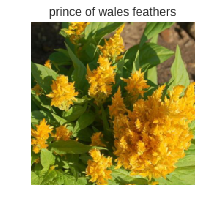

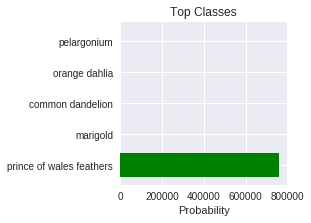

In [73]:
def sanity_checking():
    plt.rcParams["figure.figsize"] = (3,3)
    plt.rcParams.update({'font.size': 12})
    
    # Showing actual image
    image_path = (valid_dir + '/27/' + 'image_06868.jpg')
    probs, classes = predict(image_path, best_model)
    #classes = classes.cpu().numpy()
    image_to_show = process_image(image_path)
    image = imshow(image_to_show, ax = plt)
    image.axis('off')
    image.title(cat_to_name[str(classes[0])])
    image.show()
    
    # Showing Top Classes
    labels = []
    for class_index in classes:
        labels.append(cat_to_name[str(class_index)])
    y_pos = np.arange(len(labels))
    probs = probs[0]

    plt.barh(y_pos, probs, align='center', color='green')
    plt.yticks(y_pos, labels)
    plt.xlabel('Probability')
    plt.title('Top Classes')

    plt.show()

sanity_checking()